In [1]:
!pip install pyro-ppl

In [2]:
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import NUTS, MCMC
import pandas as pd
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split


# Load the California housing dataset
california = fetch_california_housing(as_frame=True)
data = pd.DataFrame(california.data, columns=california.feature_names)
data['MedHouseVal'] = california.target

# Extract the features and target
features = ['MedInc', 'AveOccup', 'HouseAge']
X = torch.tensor(data[features].values, dtype=torch.float)
y = torch.tensor(data['MedHouseVal'].values, dtype=torch.float)

# Define the Bayesian regression model with gamma priors
def model(X, y):
    # Define priors for model parameters
    num_features = X.shape[1]

    # Gamma priors for regression coefficients
    alpha = pyro.sample("alpha", dist.Gamma(1, 1))
    beta = pyro.sample("beta", dist.Gamma(torch.ones(num_features), 1))

    # Define the mean of the linear regression model
    mean = alpha + torch.matmul(X, beta)

    # Gamma prior for the observation noise
    sigma = pyro.sample("sigma", dist.Gamma(1, 1))

    # Likelihood of the observed data
    with pyro.plate("data", len(X)):
        pyro.sample("obs", dist.Normal(mean, sigma), obs=y)

# Clear the parameter store
pyro.clear_param_store()

# Run NUTS sampler to perform MCMC inference
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=200)

# Perform train/test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Run the MCMC sampler on the training data
mcmc.run(X_train, y_train)

# Get the posterior samples
posterior_samples = mcmc.get_samples()

# Extract the posterior distributions of the parameters
posterior_alpha = posterior_samples['alpha']
posterior_beta = posterior_samples['beta']
posterior_sigma = posterior_samples['sigma']


Sample: 100%|██████████| 1200/1200 [02:34,  7.79it/s, step size=2.88e-01, acc. prob=0.932]


In [4]:
from sklearn.metrics import r2_score

mean_alpha = posterior_alpha.mean().item()
mean_beta = posterior_beta.mean(dim=0).numpy()
mean_sigma = posterior_sigma.mean().item()

# Calculate the predicted values using the mean coefficients and intercept for the test set
predicted_values = mean_alpha + X_test.numpy() @ mean_beta

# Calculate R-squared for the test set
r_squared = r2_score(y_test.numpy(), predicted_values)
print(f'R-squared (R²) on the test set: {r_squared:.2f}')

R-squared (R²) on the test set: 0.49


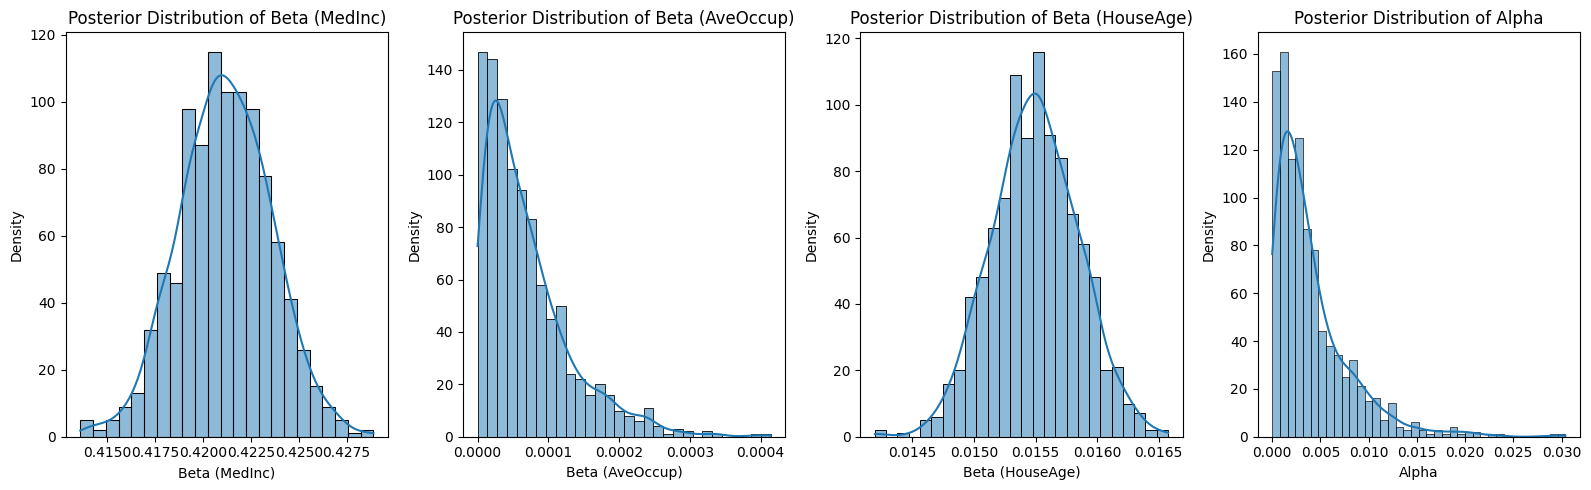

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

num_features = posterior_beta.shape[1]

fig, axes = plt.subplots(1, num_features + 1, figsize=(16, 5))

# Plot the posterior distributions of beta
for i in range(num_features):
    sns.histplot(posterior_beta[:, i], kde=True, ax=axes[i])
    axes[i].set_title(f'Posterior Distribution of Beta ({features[i]})')
    axes[i].set_xlabel(f'Beta ({features[i]})')
    axes[i].set_ylabel('Density')

# Plot the posterior distribution of alpha
sns.histplot(posterior_alpha, kde=True, ax=axes[num_features])
axes[num_features].set_title('Posterior Distribution of Alpha')
axes[num_features].set_xlabel('Alpha')
axes[num_features].set_ylabel('Density')

plt.tight_layout()
plt.show()


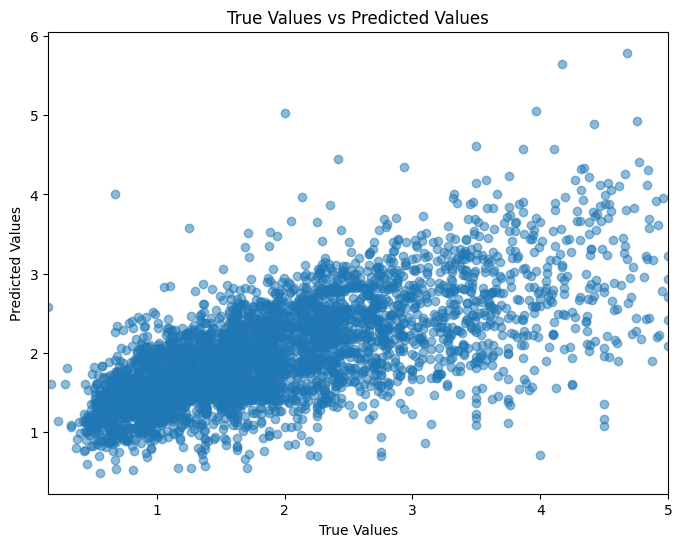

In [16]:
# Plot true values vs predicted values, excluding values greater than 5
plt.figure(figsize=(8, 6))  # Adjust the figure size if needed

# Filter values greater than 5
mask = y_test.numpy() <= 5
plt.scatter(y_test.numpy()[mask], predicted_values[mask], alpha=0.5)

plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('True Values vs Predicted Values')

# Set x-axis limits to a custom range
x_axis_range = 5  # Adjust the range as needed
plt.xlim(min(y_test.numpy()) - 0, max(y_test.numpy()))

plt.show()
